Processing the data to feed into the model

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download human-protein-atlas-image-classification

100% 17.5G/17.5G [02:26<00:00, 141MB/s]
100% 17.5G/17.5G [02:26<00:00, 128MB/s]


In [ ]:
! unzip human-protein-atlas-image-classification

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_green.png  
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_green.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_blue.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_green.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_red.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png  
  inflating: train/f5c09c38-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png  
  inflating: train/f5c09c38-bbc4-11e8-b2bc-ac1f6b6435d0_green.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2

import imageio
from imgaug import augmenters as iaa
from tqdm import tqdm

import tensorflow as tf
sns.set()

import os
print(os.listdir("../content"))

import warnings
warnings.filterwarnings("ignore")

['.config', 'sample_submission.csv', 'train.csv', 'train', 'test', 'kaggle.json', 'human-protein-atlas-image-classification.zip', 'sample_data']


In [ ]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 32

In [ ]:
path_to_train = '/content/train/'
data = pd.read_csv('/content/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

We've formed a numpy array of dictionaries, each dictionary holding two values:
1. Path of the image [Not including the colors, only the absolute path]
2. Classes of proteins in the image

In [ ]:
train_dataset_info

array([{'path': '/content/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '/content/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '/content/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '/content/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': '/content/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': '/content/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

Splitting the data into Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

### Create datagenerator
- It is a helper class that is used to generate batches of training input into our model

In [ ]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28)) # Creating label tensors for each batch where all 28 values are originally zero
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1 # Change those values to one which are present in the image
            yield batch_images, batch_labels
            
    # We club the four color channels into one image and that to our set. This can be seen below where we visualise the first five images in our set
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = cv2.resize(image, (shape[0], shape[1])) # resizing the image
        image = np.divide(image, 255) # Normalising the image
        return image  
                
    # Random augmentation based modification. This means each image appended to our set is rotated or flipped by some degree if augmentation is set to True which it is.
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

### Create model
 - Tools - Keras and Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import backend as K



def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [ ]:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,3))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('AUC')
    ax[1].plot(history.epoch, history.history["auc"], label="Train AUC")
    ax[1].plot(history.epoch, history.history["val_auc"], label="Validation AUC")
    #ax[2].set_title('acc')
    #ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    #ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    #ax[2].legend()

In [ ]:
K.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 batch_normalization_203 (Ba  (None, 299, 299, 3)      12        
 tchNormalization)                                               
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_203 (Conv2D)         (None, 8, 8, 128)         196736    
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                            

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image.open('model_plot.png')

NameError: ignored

In [ ]:
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

In [ ]:
train_generator

<generator object data_generator.create_train at 0x7f8e92d6ba50>

In [ ]:
checkpointer = ModelCheckpoint(
    '/kaggle/working/InceptionResNetV2.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-4),
    metrics=[keras.metrics.AUC(multi_label=True)])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=15, 
    verbose=1,
    callbacks=None)

Epoch 1/15
100/100 [==============================] - 216s 2s/step - loss: 0.2557 - auc: 0.4377 - val_loss: 0.1837 - val_auc: 0.4635
Epoch 2/15
100/100 [==============================] - 192s 2s/step - loss: 0.2066 - auc: 0.5226 - val_loss: 0.1794 - val_auc: 0.5038
Epoch 3/15
100/100 [==============================] - 192s 2s/step - loss: 0.1999 - auc: 0.5356 - val_loss: 0.1785 - val_auc: 0.5180
Epoch 4/15
100/100 [==============================] - 192s 2s/step - loss: 0.1940 - auc: 0.5066 - val_loss: 0.1766 - val_auc: 0.5358
Epoch 5/15
100/100 [==============================] - 192s 2s/step - loss: 0.1894 - auc: 0.5467 - val_loss: 0.1774 - val_auc: 0.5214
Epoch 6/15
100/100 [==============================] - 192s 2s/step - loss: 0.1877 - auc: 0.5313 - val_loss: 0.1762 - val_auc: 0.5333
Epoch 7/15
100/100 [==============================] - 192s 2s/step - loss: 0.1856 - auc: 0.5466 - val_loss: 0.1752 - val_auc: 0.5400
Epoch 8/15
100/100 [==============================] - 192s 2s/step - 

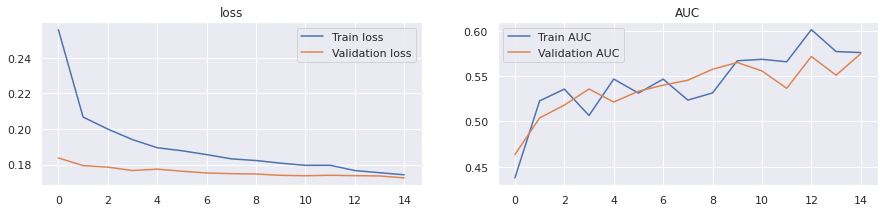

In [ ]:
show_history(history)

In [ ]:
save_history = np.stack ((history.epoch, history.history['loss'], history.history['val_loss'], history.history['auc'], history.history['val_auc']))
np.savetxt('Resultados_Entrenamiento_Modelo_Origninal.txt', save_history)